## 脸部方向预测
该项目的目标是从给定的一个头部图像，直接通过像素点来预测出它在空间中的方向。如图所示是雕像的渲染图，两图方向是相反的。

<img src="new_data/face_0000.png" width=20%> &nbsp;&nbsp;&nbsp; <img src="new_data/face_0001.png" width=20%>

我们可以从以下方面来描述姿势的特征：

* *仰角* (头部倾斜，下巴向上和向下) 
* *方位角* (头部左右旋转)

上述两张图片的仰角相似（两张图片中的鼻子基本持平），但方位角却大不相同。

我们需要一个*参数化的函数*，以某种方式将图像映射到姿势上，然后调整参数，直到该函数将面部图像映射到姿势上。也就是说，我们需要找到一个函数 $f$，它以图像为输入，以人脸姿势为输出。$f$ 必须可以用参数向量 $\theta$ 进行配置。

* $\vec{x} ～$将是人脸图像，以简单矢量的形式表示，通过展开图像来实现
* $y ～$ 将是预测的人脸姿态，以标量形式表示

#### 近似函数定义
我们将尝试逼近一个函数。这意味着有一个形式如下的目标函数：

$$L(\theta) = \|f(\vec{x};\theta)-y\|_2$$

其中，我们测量的是预测输出 $f(\vec{x};\theta)$ 与实际预期输出 $y$ 之间的差异，并尝试通过为 $\theta$ 选择一个好的设置来最小化该差异。

我会将建立一个简单的深度学习系统。专注于使用一阶优化来找到一个近似已知变换的函数。

In [52]:
try:
    import autograd.numpy as np
    from autograd import grad, elementwise_grad    
    from autograd.misc.flatten import flatten
    print("autograd succesfully imported. Everything OK so far. ")
except:
    import os
    import sys     
    print(sys.version)
    print(os.path)
    # couldn't import, install the package
    print("autograd not found.\nInstalling...")
    %pip install autograd
    print("Please restart the kernel (Kernel/Restart) and run the import cells again.")    

autograd succesfully imported. Everything OK so far. 


In [53]:
## Standard imports
from __future__ import print_function, division
import os
import sys
import binascii
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
np.set_printoptions(suppress=True)

# special hash funciton
def case_crc(s, verbose=True):
    h_crc = binascii.crc32(bytes(s.lower(), 'ascii'))
    if verbose:
        print(h_crc)
    return h_crc

uuid_simple = (("%s") % get_mac())
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (os.path,sys.path,sys.version,sys.version_info,get_mac())
uuid_system = case_crc(uuid_str,verbose=False) 

import matplotlib as mpl   
import matplotlib.pyplot as plt

print("Everything imported OK")


Everything imported OK


### 加载单张数据
new_data/face_strip.png "文件中有 698 张不同姿势的人脸图像。这些脸部图像是 64x64 灰度图像，并且
堆叠成一个很长的条状。
    
定义 `ia.load_image_gray()` 加载图像，如下所示：

(64, 64)


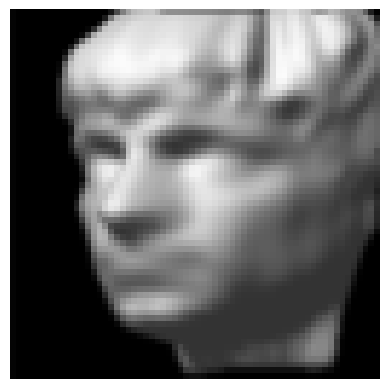

In [54]:
import skimage 
# 加载数据
def load_image_gray(fname): 
    img = skimage.io.imread(fname, plugin="pil")
    return img.astype(np.float64)

face_img = load_image_gray('new_data/face_0000.png') / 65535.0
print(face_img.shape)
ia.show_image_mpl(face_img)

#### 加载数据集
* 将 `face_strip.png` 中的人脸数据加载到单个张量 `faces` 中。
* 将其重新排列为一个 698x64x64 ，然后将其切成每幅图像的每秒*行和列，得到一个 698x32x32 张量的 "数据集"。
* 对其进行正则化
* 使用 `np.loadtxt` 以 2x698 的形式载入文件 `new_data/face_pose_degrees.txt` 并将其转置到 698x2 的数组 `face_poses` 中。

In [55]:
face_strip_load = (load_image_gray(('new_data/face_strip.png')) / 65535.0)
face_strip = face_strip_load.T
print(face_strip.shape)

faces = face_strip.reshape((698,64,64))
faces = faces.swapaxes(1,2)
print(faces.shape)

faces = faces[:,::2,::2]
print(faces.shape)

face_pose_degrees=np.loadtxt("new_data/face_pose_degrees.txt")
face_poses=face_pose_degrees.T

(44672, 64)
(698, 64, 64)
(698, 32, 32)


成功加载后，如下图所示，可以看到一个随机跳动的雕塑头像

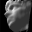

In [56]:
ia.show_gif(faces[0:10,:,:], width="150px")

## 图像输入
现在我们得到了所有图像的矩阵，该矩阵大小为689\*64\*64,但对于$\vec{x}$来说，在随后进行的图像输入中，64\*64并不能很好的进行计算，所以最好的情况是将上述的`faces`转换为698\*1024的矩阵 

In [57]:
face_inputs = faces.reshape(698,1024)
print(face_inputs.shape)

(698, 1024)


## 期望输出
$\vec{y}$ 将是每张图像的*已知*面部朝向, 是 `face_poses` 中的数据。  

我们将要定义的神经网络将把所有预测映射到 [-1,1] 范围内，因此 $\vec{y}$ 必须按比例缩放到这个范围内。人脸方向目前以 *度* 为单位存储，所以要将其转化。

In [58]:
expected_face_orientations= face_poses / 180.0

print(face_inputs.shape)
print(expected_face_orientations.shape)

(698, 1024)
(698, 2)


#### 原始数据可视化
如图所示，即为原始数据经过处理后所得到的可视化结果

Text(0.5, 1.0, 'True face orientations')

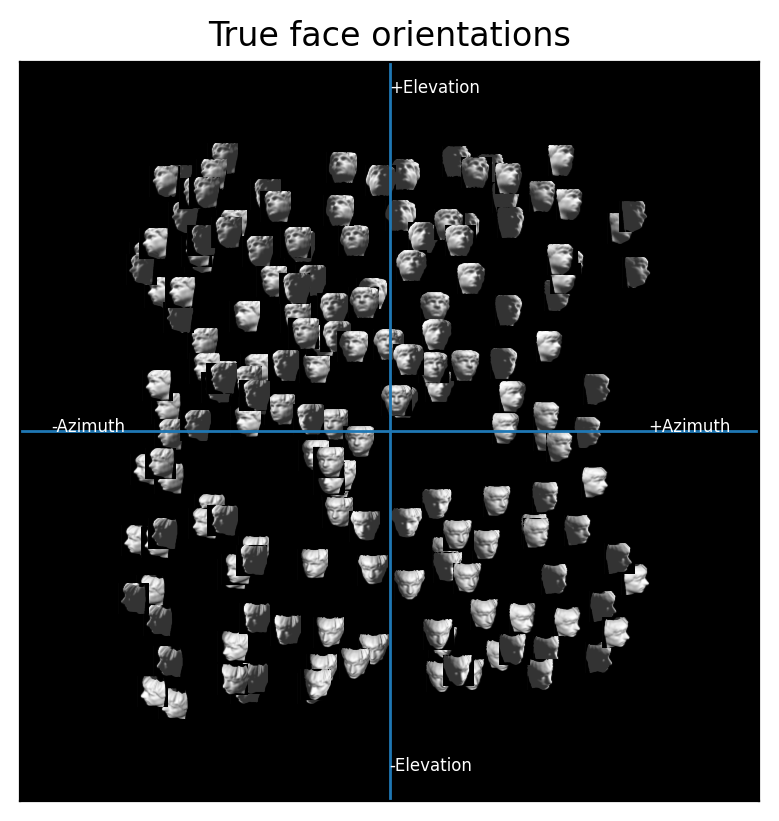

In [59]:
def show_faces(images, positions):
    # show the faces, and their orientations
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 0.025
    for i in range(0,len(positions),4):
        pos = positions[i]
        
        # show the image at the output position
        ax.imshow(images[i].reshape(faces.shape[1],faces.shape[2]), 
                  extent=[pos[0]-sz, pos[0]+sz, -pos[1]*8-sz, -pos[1]*8+sz],
                  vmin=0, vmax=1, cmap='gray')
        
    ax.axhline(0, lw=1)
    ax.axvline(0, lw=1)
    ax.text(0,0.55, '+Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0,-0.55, '-Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0.42,0.0, '+Azimuth', color='w', fontdict={"fontsize":6})
    ax.text(-0.55,0.0, '-Azimuth', color='w', fontdict={"fontsize":6})
    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Face orientations")
    
# apply to the *known* inputs and outputs
show_faces(face_inputs, expected_face_orientations)
plt.gca().set_title("True face orientations")

### 实现 
定义一个具体且简单的预测器，它接受一个向量，然后重复以下工作：

* 添加常数
* 对得到的向量进行`tanh()`运算，将其压缩在[-1,1]的范围内
* 将向量乘以不同的矩阵


在神经网络中，以上所有步骤的每一步都被看作为预测函数的一个layer




In [60]:
# 基本神经网络
def predict(x, theta, unflatten):        
    for w in unflatten(theta):          
        x = w.T @ np.tanh(x + 0.1)
    return x

# 扁平化操作 使得全部theta变为扁平化的参数向量，给定了unflatten参数，在后续过程中就可以从单一的向量中解包出矩阵
list_of_matrices = [np.zeros((3,3)), np.ones((2,4)), np.full((1,4), 2.0)]
theta, unflatten = flatten(list_of_matrices)
print(theta)
print(unflatten(theta))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.]
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


### 目标函数
给定`theta`、`unflatten`、`x`和`y`，写一个目标函数，比较一组输入和输出向量的预测输出和预期输出。使用 $L_2$ 规范。函数的形式应为：

    def face_loss(theta, unflatten, x, y):
        ...
        return l # a scalar

损失函数需要调用 `predict` 来计算 `y_prime`，即与 `y` 比较的预测输出。假设 `x` 和 `y` 是向量。

In [61]:
def face_loss(theta, unflatten, x, y):
    y_Predict = predict(x,theta,unflatten)
    return np.linalg.norm(y_Predict - y,2)

### 网络结构
用于预测的矩阵形状的选择会影响建立变换模型的能力。

在这个项目中，我们知道有 1024 维的输入（32x32 人脸图像分解成平面向量）和 2 维的输出（姿势向量）。因此，我们必须以 1024 维向量为起点，以 2 维向量为终点。

但是，我们可以在预测函数中引入任意数量的中间矩阵。这样可以调整的参数就更多了，学习映射的方式也更加灵活；这使得预测函数更加灵活。如果我们有更多的中间矩阵，我们就可以更有力地扭曲空间。

一个非常简单的模型可能只有一个 1024,2 

一个更复杂的模型可能有一个由四个矩阵依次组成的映射：

    W[0] W[1] W[2] W[3］
    1024,32 -> 32,16 -> 16,8 -> 8,2

这种 "结构 "将 1024 维输入向量映射到某个 32 维空间，然后映射到某个 16 维空间，再映射到某个 8 维空间，最后映射到 2 维输出。每个矩阵的输出维度都必须与下一个矩阵的输入维度相匹配。矩阵 W[0]、W[1]、W[2]、W[3] 规定了每一层的向量如何映射到下一层。

这些矩阵的大小几乎是任意选择的。它们可以是 1024->50->20->2 或 1024->10->10->10->10->10->15->2，也可以有许多其他变化。这些都代表了可以学习的不同类型的函数，但事实证明，具体的选择并不重要。更多元素的矩阵意味着更灵活的函数，可以学习更复杂的东西；但更难有效优化。


### 网络初始化
在初始化的过程中，需要为优化过程设置一些初始条件，在这个过程中，由于不知道每个矩阵中元素的值具体是多少，所以只好随机设置。

在这个部分按照如下来设置：
* 创建一个函数，为预测函数生成初始条件。
* 该函数接收矩阵shape列表，并创建相应的随机填充矩阵列表。 
* 生成的每个矩阵都具有指定的形状。 
* 该函数需要一个参数 `sigma` 来指定所选随机值的分布。它返回矩阵列表的 **flattened** 版本，以及相应的 `unflatten` 函数。

In [62]:
def initial_conditions(shape_list, sigma):
    res = []
    for x in shape_list:
        res.append(np.random.normal(0,sigma,x))

    return flatten(res)

## 随机预测
可以使用 predict 来查看将此函数应用于人脸图像的效果。由于所有矩阵都是随机的，因此结果将是随机的状态，所绘制的位置与人脸的真实方向毫无关系。

Text(0.5, 1.0, 'Random face orientations')

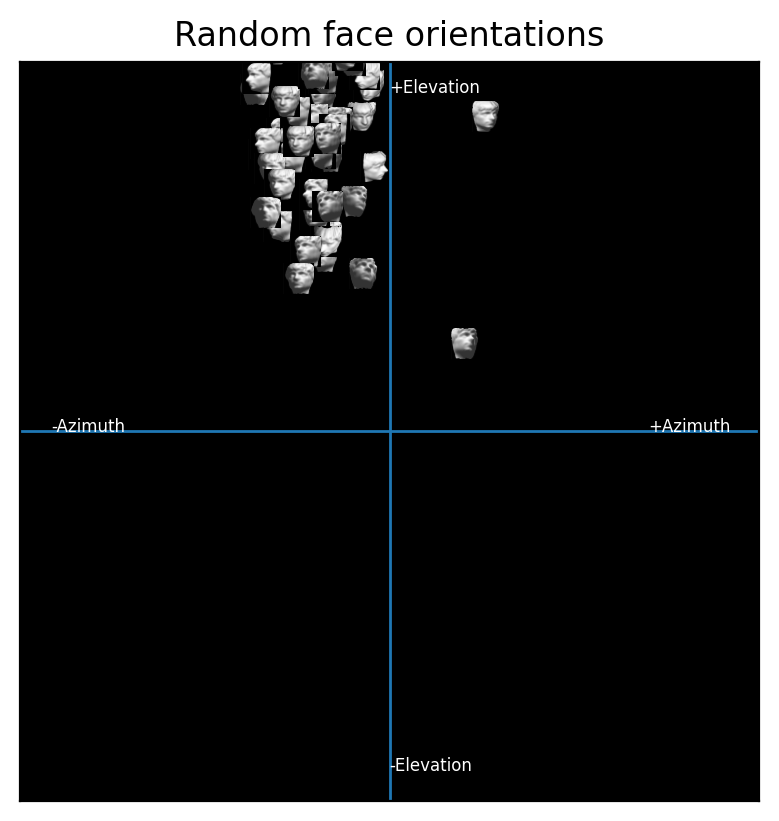

In [63]:
random_theta, unflatten = initial_conditions( [[1024,32], [32, 16],  [16, 8], [8,2]], 0.2)
predicted_outputs = [predict(face_inputs[i], random_theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))
plt.gca().set_title("Random face orientations")

In [64]:
# 计算每一个匹配的输入输出的目标函数之和
def total_face_loss(theta, unflatten):
    total=0
    for i in range (698):
        total=total+face_loss(random_theta, random_unflatten,face_inputs[i], expected_face_orientations[i])
    return total

np.random.seed(2018)
# create some test initial conditions
random_theta, random_unflatten = flatten([np.random.normal(0,1,(1024,4)), np.random.normal(0,1,(4,2))])

## 梯度下降
在这个部分可以使用随机搜索、爬坡算法、梯度下降

In [65]:
grad_face_loss=grad(face_loss)
flat, unflatten = flatten(np.array([1,2,3]))
test_network = [np.array([[1,0.5,-0.5], [0.0, 2.0, -1.0]]).T, 
                np.array([[2.0, 1.0], [1.0, -1.0]]).T]
test_theta, test_unflatten = flatten(test_network)


### SGD 
sgd_learn` 具体的思路如下：
* 接收一个矩阵`shapes`列表、一个用来指定这些矩阵随机初始化的`sigma`、一个`step`大小和一个`iterations`次数
* 使用上面定义的 `initial_condition()` 函数，从这组形状中生成初始 `theta` 。
* 为每次给定的迭代次数
    * 随机选择*个*输入向量（从`inputs`中）和匹配的输出向量（从`outputs`中）。
    * 计算该图像/输出对的目标函数梯度
    * 在梯度方向上调整 `theta` 步长，步长按比例调整
    * 每迭代 500 次（即每 500 个随机数据点）打印一次迭代次数，以便查看函数是否正常运行
    * 评估每次迭代的目标函数，并在 print 语句中打印出最后 500 次迭代的目标函数值总和；将该值追加到一个名为 `hist_loss_500` 的数组中
    
* 返回扁平化向量、相应的非扁平化函数和每次迭代的损失 


In [66]:
import random
from tqdm import tqdm

def sgd_learn(shapes, inputs, outputs, sigma=0.1, step=0.1, iters=10000):    
    # YOUR CODE HERE
    hist_loss_500  = []
    loss = 0
    theta, unflatten = initial_conditions(shapes,sigma)
    pbar = tqdm(range(1, iters+1), total=iters)
    for i in pbar:
        num = random.randint(0,697)
        theta -= step * grad_face_loss(theta,unflatten,inputs[num],outputs[num])
        loss += face_loss(theta,unflatten,inputs[num],outputs[num])
        if i % 500 == 0:
            pbar.set_description(f"Epoch: {int(i/500)} Step: {i} Loss: {loss:.4f}")
            hist_loss_500.append(loss)
            loss = 0
    w = theta

    return w, unflatten, hist_loss_500

### 验证SGD 

In [67]:
test_theta, test_unflatten, hist_loss_500 = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.1, 0.1, 1)
unflattened = test_unflatten(test_theta)

test_theta, test_unflatten, test_hist_loss_500 = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.01, 0.001, 0)
before_losses = [face_loss(test_theta, test_unflatten, x,y) for x,y in zip(face_inputs, expected_face_orientations)]

test_theta, test_unflatten, test_hist_loss_500 = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.02, 0.001, 200)
after_losses = [face_loss(test_theta, test_unflatten, x,y) for x,y in zip(face_inputs, expected_face_orientations)]

print("Mean loss before optimising %.2f; after optimising %.2f" % (np.mean(before_losses),  np.mean(after_losses)))

100%|██████████| 1/1 [00:00<00:00, 841.22it/s]
0it [00:00, ?it/s]
100%|██████████| 200/200 [00:00<00:00, 5209.02it/s]

Mean loss before optimising 0.40; after optimising 0.13


 ### 迭代
设置迭代的次数及城市的sigma去优化超参数


Epoch: 60 Step: 30000 Loss: 4.5927: 100%|██████████| 30000/30000 [09:31<00:00, 52.47it/s]


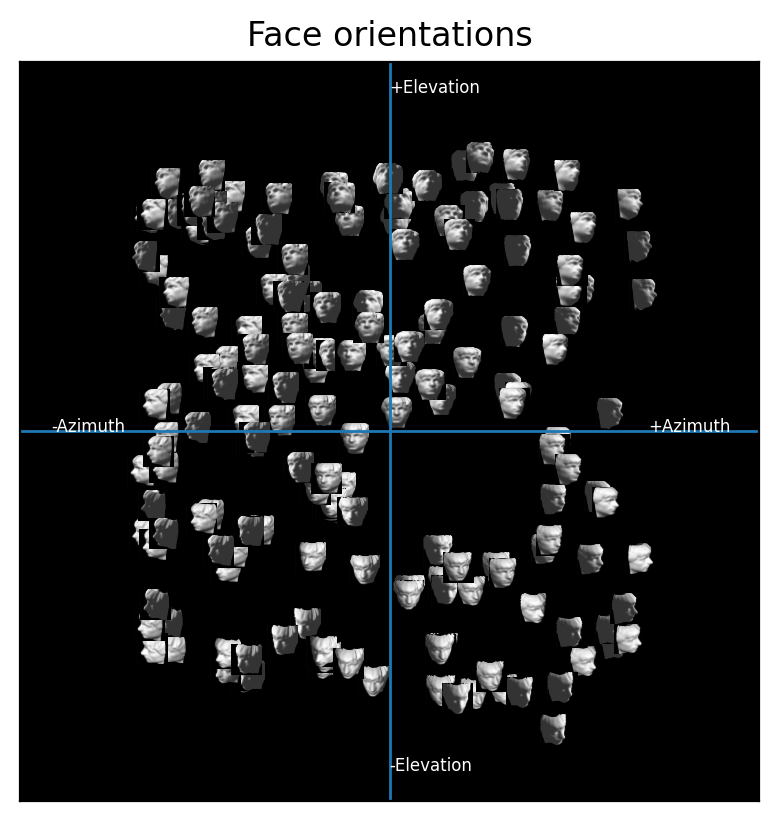

In [68]:
np.random.seed(2023)
theta, unflatten, hist_loss_500 = sgd_learn([[1024,512],[512,32], [32, 16],  [16, 8], [8,2]], face_inputs, expected_face_orientations, 0.1, 0.01, 30000)
predicted_outputs = [predict(face_inputs[i], theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))

### Loss可视化

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[58.131009774095745, 20.261867365109797, 15.840884319919615, 13.179428695464113, 11.833297954866293, 10.193178730066698, 10.207251439112719, 9.538325127798576, 9.003176247296931, 8.546075476070936, 8.322353540167915, 8.42374857355555, 7.799973802301511, 7.089244008293103, 6.955687005289632, 7.456213498030788, 6.78061670617133, 6.437700304362704, 6.583950726711807, 6.385047355632017, 6.336756998014783, 6.012815051306953, 6.57464586864028, 6.126184134145966, 6.288805885989803, 6.039131210032203, 5.8288894050429665, 5.947797933695448, 5.510965887366978, 5.871260088630541, 5.492679762314234, 5.519213630963165, 5.744392424610586, 5.422190269988672, 5.402514432681219, 5.309915458578219, 5.368437393807799, 5.514523709816378, 5.181882134970798, 5.264869377921794, 5.337301562645015, 5.133973970241397, 5.262819361928179, 5.643787601886631, 5.1776458339213, 5.204762847775931, 5.11029335018695, 4.914280058227916, 5.0915249178284565, 5.187256502556804, 4.949192067121652, 4.840723351836689, 4.967984

Text(0, 0.5, 'Objective function value')

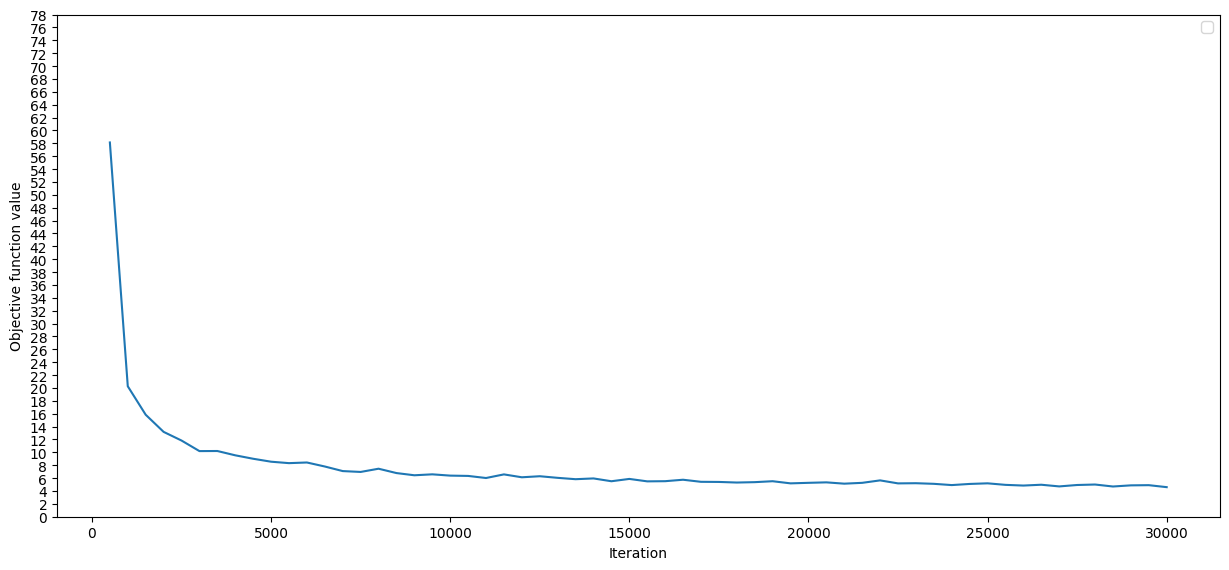

In [82]:

fig_b9 = plt.figure(figsize=(15,30))
ax = fig_b9.add_subplot(4,1,1)

import matplotlib.pyplot as plt

print(hist_loss_500)
print(len(hist_loss_500))

# x = range(500, 1000001, 50000)
x = range(500, 30001, 500)
ax.plot(x,hist_loss_500)

y_ticks = np.arange(0, 80, 2)  # 设置y轴每1的间隔一个刻度
ax.set_yticks(y_ticks)

ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective function value")
